In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
except:
	pass


 ## Car and Real MPG over time
 In the values that I recorded, I kept track of two different MPG values:
 * **Car MPG**: The average MPG for a single tank as reported by my car's dashboard
 * **Real MPG**: The MPG calculated by dividing the number of miles I drove
   (reported by my car) divided by the number of gallons I put in after that
   drive


 Basically this means that I had a measurement of the MPG value that my car was
 telling me as well as the MPG value that I believed to be the 'true' value.
 To control for the amount of fuel, I would put the pump in, pump until it
 automatically clicked off, and pumped no more.

 So now that's out of the way, let's take a look at these two values:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Some extra stuff to stop complaints when plotting the data column
from  pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [3]:
# Load the data
db = pd.read_pickle('data/data_formatted.pkl')

# Remove the 'notes' column (it's not necessary at this point)
db = db.drop(['notes'], axis=1)
# Trim the NaN values
db = db[~db.isin([np.nan]).any(1)]


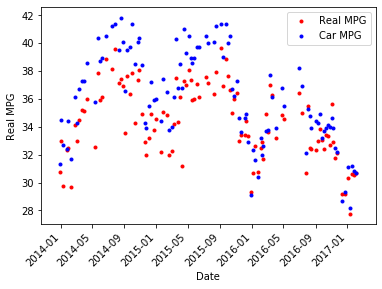

In [4]:
# Setup the axes
plt.xlabel('Date')
plt.ylabel('Real MPG')
plt.xticks(rotation=45, ha='right')
plt.scatter(db.Date, db['Real MPG'], color='red', marker='.', label='Real MPG')
plt.scatter(db.Date, db['Car MPG'], color='blue', marker='.', label='Car MPG')
plt.legend() # Identify the values


 Hmmm, that's a bit of a messy plot. It would be nice to have a sort of 'trend-
 line' that can guide the eye. I don't currently have anything that can do that,
 so let me go write a method really quick...

In [5]:
def moving_avg(x, nbins=2):
    """
    Generates a moving average of a given bin and 'nbins' on either side

    Parameters
    ----------
    x : numpy.array
        Array of values
    nbins : int
        Number of bins on either side to average
    
    Returns
    -------
    Array representing a moving average
    """
    # Copy the array
    y = np.array(x)

    # Pad the front and back with NaN's
    y = np.insert(y, 0, [np.nan]*nbins)
    y = np.insert(y, len(y), [np.nan]*nbins)

    # Convolve with with an array of 1's
    width = 2*nbins + 1
    return np.convolve(y, np.ones(width), 'valid') / width
   

In [6]:
mv_avg_real_mpg = moving_avg(np.array(db['Real MPG']))
mv_avg_car_mpg  = moving_avg(np.array(db['Car MPG']))


 There we go, so let's plot that all up

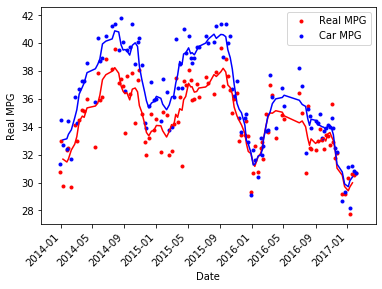

In [7]:
plt.xlabel('Date')
plt.ylabel('Real MPG')
plt.xticks(rotation=45, ha='right')
plt.scatter(db.Date, db['Real MPG'], color='red', marker='.', label='Real MPG')
plt.scatter(db.Date, db['Car MPG'], color='blue', marker='.', label='Car MPG')
plt.plot(db.Date, mv_avg_real_mpg, color='red', ls='-')
plt.plot(db.Date, mv_avg_car_mpg, color='blue', ls='-')
plt.legend() # Identify the values


 This is interesting. It looks like my car was reporting a higher value of MPG
 than I actually was using! That suggests my car was doing something funny.

 If we look, though, at 2016 it appears the difference between my car and the
 actual MPG get's a little closser together, so let's see if this is actually
 correct. I'll do that by plotting a distribution of 'Real-Car MPG'

In [8]:
# Get the 2014 data
db_2014 = db[db.Date < pd.datetime(2015,1,1)]
db_2014 = db_2014[db_2014.Date >= pd.datetime(2014,1,1)]
# Get the 2015 data
db_2015 = db[db.Date < pd.datetime(2016,1,1)]
db_2015 = db_2015[db_2015.Date >= pd.datetime(2015,1,1)]
# Get the 2016 data
db_2016 = db[db.Date < pd.datetime(2017,1,1)]
db_2016 = db_2016[db_2016.Date >= pd.datetime(2016,1,1)]
# Get the 2017 data
db_2017 = db[db.Date < pd.datetime(2018,1,1)]
db_2017 = db_2017[db_2017.Date >= pd.datetime(2017,1,1)]

# Function to compute percent offset
def off_prcnt(measured,real):
    return (measured-real)

# Generate an offset percentage
offset_vals = []
offset_labels = []
offset_vals.append(off_prcnt(db_2014['Car MPG'],db_2014['Real MPG']))
offset_vals.append(off_prcnt(db_2015['Car MPG'],db_2015['Real MPG']))
offset_vals.append(off_prcnt(db_2016['Car MPG'],db_2016['Real MPG']))
offset_vals.append(off_prcnt(db_2017['Car MPG'],db_2017['Real MPG']))
yr = 2014
for vals in offset_vals:
    # Compute average and std. deviation
    avg = np.average(vals)
    sigma = np.var(vals)
    # Create the label
    offset_labels.append(r'{}: $\mu={:0.2f},\ \sigma={:0.2f}$'.format(yr, avg, sigma))
    yr += 1
colors = ['blue', 'green', 'red', 'yellow']


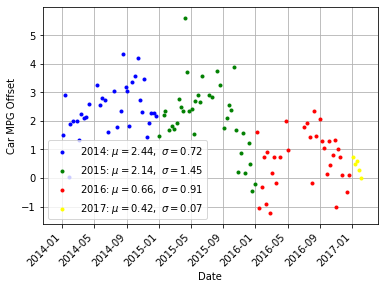

In [9]:
plt.xlabel('Date')
plt.ylabel('Car MPG Offset')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.scatter(db_2014.Date, offset_vals[0], 
            color='blue', marker='.', label=offset_labels[0], zorder=3)
plt.scatter(db_2015.Date, offset_vals[1], 
            color='green', marker='.', label=offset_labels[1], zorder=3)
plt.scatter(db_2016.Date, offset_vals[2], 
            color='red', marker='.', label=offset_labels[2], zorder=3)
plt.scatter(db_2017.Date, offset_vals[3], 
            color='yellow', marker='.', label=offset_labels[3], zorder=3)
plt.legend()


 Holdup ... what's that weird point in 2015 that appears to be REALLY high up?
 Let's do some investigation to find that one point

In [10]:
# Get all points in the distribution where the difference is more than 15 in 
# the 2015 distribution
outlier_indx = offset_vals[1].idxmax()
print(f'Outlier index: {outlier_indx}')
print(f'Outlier info:\n{db_2015.loc[[outlier_indx]]}')


Outlier index: 112
Outlier info:
          Date  Miles  Gas Pumped  Price/Gal  Car MPG  Avg Spd  Car gas  \
112 2015-04-10  419.8      13.462      2.259     36.8     46.8     12.5   

     Price/Barrel  Real MPG   paid ($)   Latitude  Longitude  
112         51.64    31.184  30.410658  41.586835 -93.624959  


 Okay, well, it doesn't look like there's anything particularly weird with that
 specific data point, so I guess I'll leave it be.

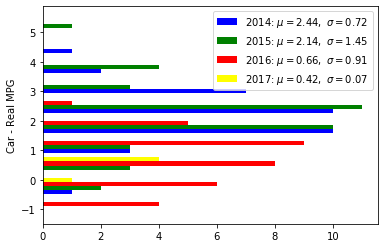

In [11]:
# Generate some histograms
plt.ylabel('Car - Real MPG')
plt.hist(offset_vals, 10, stacked=False, label=offset_labels, color=colors,
         orientation='horizontal')
plt.legend()


 From the looks of it, it appears that the MPG get's more and more accurate
 over time. I'm not sure why this is, it could be that there was a recall that
 happened sometime near the end of 2015. On the otherhand, it could be that my
 car decided to trust me with the "true" MPG. I don't know, but it's interesting
 to see that it did in fact change over time.

 ## Correlating with Date
 Before we can process this data more deeply, we need to figure out the best
 way to format the date information. We will see which of the following has the
 best correlation with the MPG:

 1. Day of year
 1. Day of month (1-31)
 1. Day of week (0-6)
 1. Week of year
 1. Year (raw year)
 1. Month (0-11)
 1. Quarter (i.e. financial quarter)


 ### Predictions
 Before we begin, let's make some predictions! Specifically, here's how I
 think the above will shake out:

 1. **Day of year**: Good, the values appear to cycle yearly
 1. **Day of month**: Not good, the relationship looks like it cycles yearly, not monthly
 1. **Day of week**: Not good, again, it's cyclical by year, not week
 1. **Week of year**: Good, the values cycle yearly
 1. **Year**: Not good
 1. **Month**: Good, the values cycle yearly
 1. **Quarter**: Good, quarter cycles yearly


 Regarding the yearly based values ('Day of year', 'Month', 'Week of year',
 Quarter') I think the most correlating way would be to do winter, fall/spring,
 and summer last. That gives probably the best correlation.

 ### Gener
 To do this I will first generate a method that will take care of the plotting
 and the computation of the correlation between the two values

In [12]:
def correlation(par1, par2, xlabel='', ylabel='', title='', corr_list=None):
    """
    Computes the correlation between 'par1' and 'par2'. This method also plots
    the distribution of the two parameters.

    Parameters
    ----------
    par1 : numpy.array
        Array of values
    par2 : numpy.array
        Array of values
    xlabel : str
        Label for par1
    ylabel : str
        Label for par2
    title : str
        Prefix for the plot title
    corr_list : numpy.array
        List of correlations to add this value to

    Returns
    -------
    Correlation coefficient between 'par1' and 'par2'
    """
    # Compute the correlation
    corr = np.corrcoef(par1, par2)[0][1]

    # Plot the variables with each other
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'{title}: |corr| = {np.abs(corr)}')
    plt.scatter(par1, par2, marker='.', color='blue')

    # Add the correlation to the list
    if corr_list is not None:
        corr_list.append([np.abs(corr), title])
    return corr


 Now that we have that out of the way, let's generate those plots!

In [13]:
# Keep track of the correlations so that we can sort them later
corr_list = []


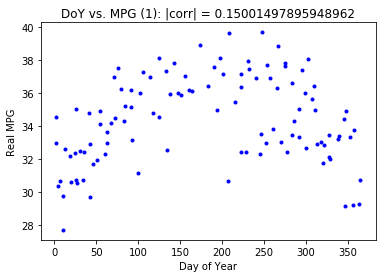

In [14]:
date1 = [d.dayofyear for d in db.Date]
corr1 = correlation(date1, db['Real MPG'], xlabel='Day of Year', ylabel='Real MPG', title='DoY vs. MPG (1)', corr_list=corr_list)


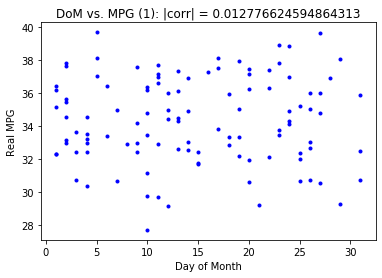

In [15]:
date2 = [d.day for d in db.Date]
corr2 = correlation(date2, db['Real MPG'], xlabel='Day of Month', ylabel='Real MPG', title='DoM vs. MPG (1)', corr_list=corr_list)


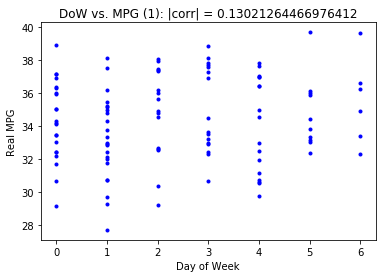

In [16]:
date3 = [d.dayofweek for d in db.Date]
corr3 = correlation(date3, db['Real MPG'], xlabel='Day of Week', ylabel='Real MPG', title='DoW vs. MPG (1)', corr_list=corr_list)


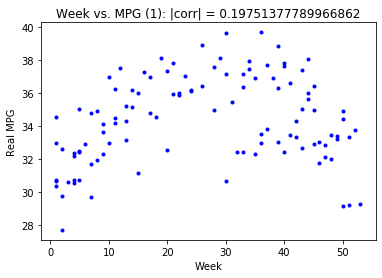

In [17]:
date4 = [d.weekofyear for d in db.Date]
corr4 = correlation(date4, db['Real MPG'], xlabel='Week', ylabel='Real MPG', title='Week vs. MPG (1)', corr_list=corr_list)


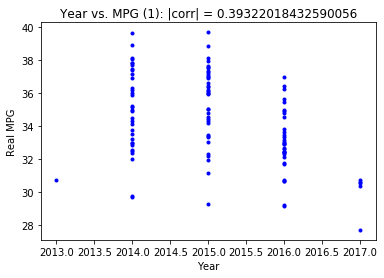

In [18]:
date5 = [d.year for d in db.Date]
corr5 = correlation(date5, db['Real MPG'], xlabel='Year', ylabel='Real MPG', title='Year vs. MPG (1)', corr_list=corr_list)


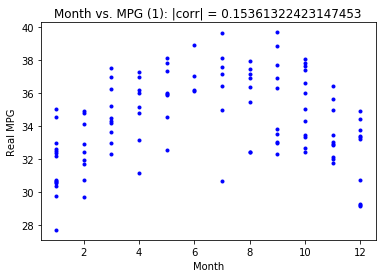

In [19]:
date6 = [d.month for d in db.Date]
corr6 = correlation(date6, db['Real MPG'], xlabel='Month', ylabel='Real MPG', title='Month vs. MPG (1)', corr_list=corr_list)


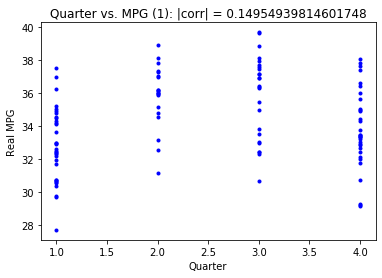

In [20]:
date7 = [d.quarter for d in db.Date]
corr7 = correlation(date7, db['Real MPG'], xlabel='Quarter', ylabel='Real MPG', title='Quarter vs. MPG (1)', corr_list=corr_list)


 Okay, now let's try shifting the dates back by a quarter of a year (91 days)
 in order to put the yearly cycle more in line with what I think it should be

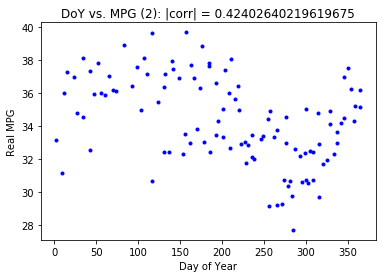

In [21]:
dates = db.Date - pd.to_timedelta(91, unit='d')
date1 = [d.dayofyear for d in dates]
corr1 = correlation(date1, db['Real MPG'], xlabel='Day of Year', ylabel='Real MPG', title='DoY vs. MPG (2)', corr_list=corr_list)


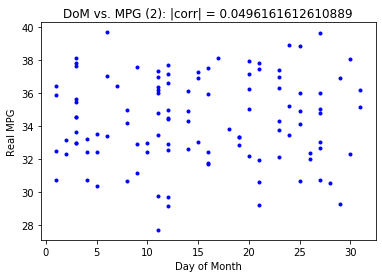

In [22]:
date2 = [d.day for d in dates]
corr2 = correlation(date2, db['Real MPG'], xlabel='Day of Month', ylabel='Real MPG', title='DoM vs. MPG (2)', corr_list=corr_list)


 Ignore the 'date of week' as it shouldn't be any different

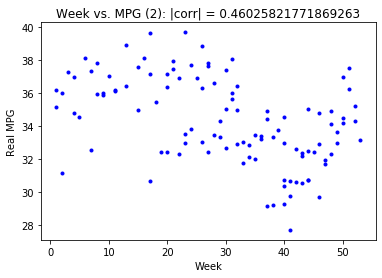

In [23]:
date4 = [d.weekofyear for d in dates]
corr4 = correlation(date4, db['Real MPG'], xlabel='Week', ylabel='Real MPG', title='Week vs. MPG (2)', corr_list=corr_list)


 Note that we'll ignore the 'year' plot as it doesn't make sense any longer

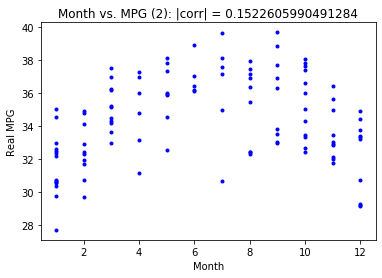

In [24]:
dates = db.Date - pd.to_timedelta(3, unit='m')
date6 = [d.month for d in dates]
corr6 = correlation(date6, db['Real MPG'], xlabel='Month', ylabel='Real MPG', title='Month vs. MPG (2)', corr_list=corr_list)


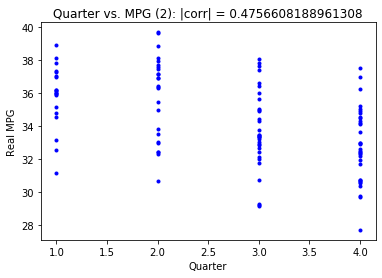

In [25]:
date7 = [d.quarter-1 for d in db.Date]
date7 = [(d+4 if d <= 0 else d) for d in date7]
corr7 = correlation(date7, db['Real MPG'], xlabel='Quarter', ylabel='Real MPG', title='Quarter vs. MPG (2)', corr_list=corr_list)


 Taking the above values, let us sort them and then print the results. This
 should show the order of how best to represent the date for predicting the
 value of MPG.

In [26]:
corr_sorted = np.sort(corr_list, axis=0)
for corr in reversed(corr_sorted):
    print(f'{corr[1]:20s}: {corr[0]}')


Year vs. MPG (1)    : 0.4756608188961308
Week vs. MPG (2)    : 0.46025821771869263
Week vs. MPG (1)    : 0.42402640219619675
Quarter vs. MPG (2) : 0.39322018432590056
Quarter vs. MPG (1) : 0.19751377789966862
Month vs. MPG (2)   : 0.15361322423147453
Month vs. MPG (1)   : 0.1522605990491284
DoY vs. MPG (2)     : 0.15001497895948962
DoY vs. MPG (1)     : 0.14954939814601748
DoW vs. MPG (1)     : 0.13021264466976412
DoM vs. MPG (2)     : 0.0496161612610889
DoM vs. MPG (1)     : 0.012776624594864313


 Here are the take-aways:
 * As expected, shifting the dates yields a better correlation for pretty much
   every variable.
 * 'week of year' and the raw 'year' values appear to be the best variables